In [1]:
# Basic libraries
import numpy as np
import pandas as pd

# For basic checks and splitting later
from sklearn.model_selection import train_test_split


In [2]:
# Reproducibility
np.random.seed(42)

# Number of samples and covariates
n = 3000      # rows (individuals)
p = 50        # covariates X1 ... X50

# 1) Generate covariates X (high-dimensional nuisance variables)
X = np.random.normal(loc=0, scale=1, size=(n, p))  # standard normal
x_cols = [f"X{i+1}" for i in range(p)]

# 2) Define treatment assignment T based on some of the Xs (confounding)
#    This creates *confounding* because X affects both T and Y.
logit_T = 0.5 * X[:, 0] - 0.3 * X[:, 1] + 0.2 * X[:, 2] + 0.1 * X[:, 3]
propensity = 1 / (1 + np.exp(-logit_T))        # P(T=1 | X)
T = np.random.binomial(1, propensity)          # draw 0/1 treatment

# 3) Define a heterogeneous treatment effect tau(X)
#    Treatment effect depends on X1 and X2 → heterogeneity in CATE.
tau = 1.0 + 0.5 * X[:, 0] + 0.5 * X[:, 1]

# 4) Define baseline outcome f(X) (what happens regardless of treatment)
f_X = (
    2
    + 0.5 * X[:, 0]
    - 0.5 * X[:, 1]
    + 0.3 * X[:, 2]
    + 0.1 * np.sum(X[:, 3:10], axis=1)   # a bit of interaction from X4..X10
)

# 5) Random noise
epsilon = np.random.normal(0, 1, size=n)

# 6) Final outcome:
#    Y = f(X) + tau(X) * T + noise
Y = f_X + tau * T + epsilon

# 7) Put into a DataFrame
data = pd.DataFrame(X, columns=x_cols)
data["T"] = T
data["Y"] = Y

data.head()


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X43,X44,X45,X46,X47,X48,X49,X50,T,Y
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.542560,...,-0.115648,-0.301104,-1.478522,-0.719844,-0.460639,1.057122,0.343618,-1.763040,1,1.940448
1,0.324084,-0.385082,-0.676922,0.611676,1.031000,0.931280,-0.839218,-0.309212,0.331263,0.975545,...,-0.702053,-0.327662,-0.392108,-1.463515,0.296120,0.261055,0.005113,-0.234587,0,2.243579
2,-1.415371,-0.420645,-0.342715,-0.802277,-0.161286,0.404051,1.886186,0.174578,0.257550,-0.074446,...,-1.607483,0.184634,0.259883,0.781823,-1.236951,-1.320457,0.521942,0.296985,1,1.601631
3,0.250493,0.346448,-0.680025,0.232254,0.293072,-0.714351,1.865775,0.473833,-1.191303,0.656554,...,0.214094,-1.245739,0.173181,0.385317,-0.883857,0.153725,0.058209,-1.142970,0,2.068782
4,0.357787,0.560785,1.083051,1.053802,-1.377669,-0.937825,0.515035,0.513786,0.515048,3.852731,...,0.504987,0.865755,-1.200296,-0.334501,-0.474945,-0.653329,1.765454,0.404982,1,3.674846


In [3]:
print("Shape of data:", data.shape)
print("\nFirst 5 rows:")
display(data.head())

print("\nSummary of treatment and outcome:")
display(data[["T", "Y"]].describe())


Shape of data: (3000, 52)

First 5 rows:


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X43,X44,X45,X46,X47,X48,X49,X50,T,Y
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.542560,...,-0.115648,-0.301104,-1.478522,-0.719844,-0.460639,1.057122,0.343618,-1.763040,1,1.940448
1,0.324084,-0.385082,-0.676922,0.611676,1.031000,0.931280,-0.839218,-0.309212,0.331263,0.975545,...,-0.702053,-0.327662,-0.392108,-1.463515,0.296120,0.261055,0.005113,-0.234587,0,2.243579
2,-1.415371,-0.420645,-0.342715,-0.802277,-0.161286,0.404051,1.886186,0.174578,0.257550,-0.074446,...,-1.607483,0.184634,0.259883,0.781823,-1.236951,-1.320457,0.521942,0.296985,1,1.601631
3,0.250493,0.346448,-0.680025,0.232254,0.293072,-0.714351,1.865775,0.473833,-1.191303,0.656554,...,0.214094,-1.245739,0.173181,0.385317,-0.883857,0.153725,0.058209,-1.142970,0,2.068782
4,0.357787,0.560785,1.083051,1.053802,-1.377669,-0.937825,0.515035,0.513786,0.515048,3.852731,...,0.504987,0.865755,-1.200296,-0.334501,-0.474945,-0.653329,1.765454,0.404982,1,3.674846



Summary of treatment and outcome:


,T,Y
count,3000.000000,3000.000000
mean,0.496667,2.540936
std,0.500072,1.537056
min,0.000000,-2.281297
25%,0.000000,1.487912
50%,0.000000,2.497006
75%,1.000000,3.564516
max,1.000000,7.728733


In [5]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold

# Features, treatment, outcome
X_mat = data[[c for c in data.columns if c.startswith("X")]].values
T_vec = data["T"].values
Y_vec = data["Y"].values

n = X_mat.shape[0]
K = 5  # 5-fold cross-fitting (you can mention this in the report)

# Placeholders for cross-fitted predictions
m_hat = np.zeros(n)  # E[Y | X]   (outcome model)
e_hat = np.zeros(n)  # E[T | X]   (propensity / treatment model)

# Define ML models for nuisance functions
outcome_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

treatment_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

kf = KFold(n_splits=K, shuffle=True, random_state=42)

# ----- Cross-fitting loop -----
for train_idx, test_idx in kf.split(X_mat):
    X_train, X_test = X_mat[train_idx], X_mat[test_idx]
    Y_train, Y_test = Y_vec[train_idx], Y_vec[test_idx]
    T_train, T_test = T_vec[train_idx], T_vec[test_idx]

    # Fit outcome model E[Y|X] on training folds
    outcome_model.fit(X_train, Y_train)
    m_hat[test_idx] = outcome_model.predict(X_test)

    # Fit treatment model E[T|X] (propensity) on training folds
    treatment_model.fit(X_train, T_train)
    e_hat[test_idx] = treatment_model.predict_proba(X_test)[:, 1]

# Attach cross-fitted predictions to the dataframe (useful later)
data["m_hat"] = m_hat
data["e_hat"] = e_hat

data[["Y", "T", "m_hat", "e_hat"]].head()


,Y,T,m_hat,e_hat
0,1.940448,1,3.338371,0.565
1,2.243579,0,2.825485,0.580
2,1.601631,1,1.609480,0.455
3,2.068782,0,2.892406,0.500
4,3.674846,1,3.369335,0.575


In [6]:
# STEP 3: Residualized outcome and treatment
Y_res = data["Y"] - data["m_hat"]
T_res = data["T"] - data["e_hat"]

# Final DML regression (OLS)
from sklearn.linear_model import LinearRegression

dml_model = LinearRegression()
dml_model.fit(T_res.values.reshape(-1,1), Y_res.values)

theta_hat = dml_model.coef_[0]
theta_hat


np.float64(0.988892714240645)

In [7]:
from sklearn.ensemble import RandomForestRegressor

# --- Step 4: T-Learner for CATE estimation ---

# Separate treated and control groups
treated = data[data["T"] == 1]
control = data[data["T"] == 0]

X_cols = [c for c in data.columns if c.startswith("X")]

X_treat = treated[X_cols]
Y_treat = treated["Y"]

X_control = control[X_cols]
Y_control = control["Y"]

# Train two separate models
rf_treat = RandomForestRegressor(n_estimators=300, random_state=42)
rf_control = RandomForestRegressor(n_estimators=300, random_state=42)

rf_treat.fit(X_treat, Y_treat)
rf_control.fit(X_control, Y_control)

# Predict potential outcomes for everyone
mu1 = rf_treat.predict(data[X_cols])   # Y(1)
mu0 = rf_control.predict(data[X_cols]) # Y(0)

# Estimated heterogeneous treatment effect τ(X)
cate = mu1 - mu0

data["CATE"] = cate
data["CATE"].head()


,CATE
0,-0.422767
1,1.296099
2,0.171041
3,1.280684
4,1.279746


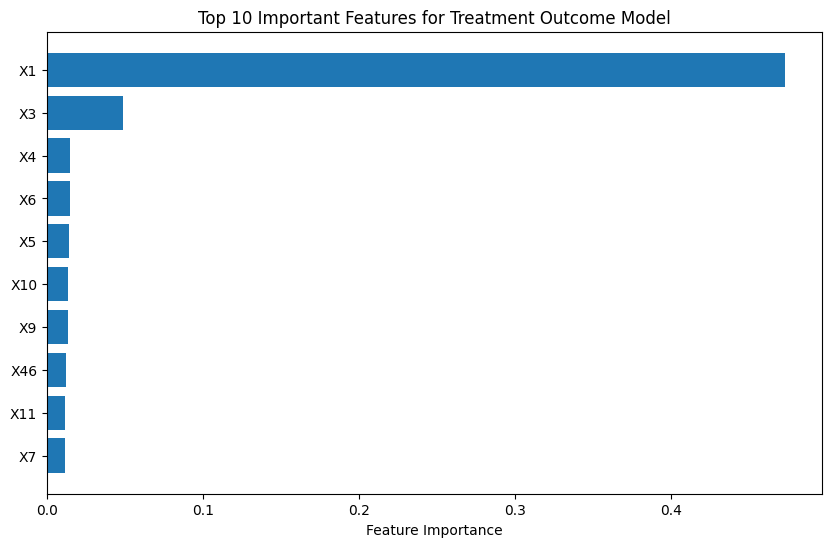

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Using the treatment model feature importance
importances = rf_treat.feature_importances_

# Sort and pick top 10
indices = np.argsort(importances)[-10:]
top_features = np.array(X_cols)[indices]
top_importances = importances[indices]

plt.figure(figsize=(10,6))
plt.barh(top_features, top_importances)
plt.title("Top 10 Important Features for Treatment Outcome Model")
plt.xlabel("Feature Importance")
plt.show()


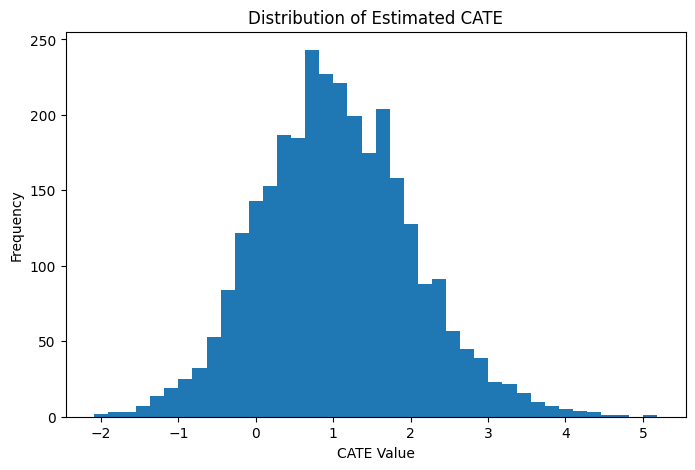

In [9]:
plt.figure(figsize=(8,5))
plt.hist(data["CATE"], bins=40)
plt.title("Distribution of Estimated CATE")
plt.xlabel("CATE Value")
plt.ylabel("Frequency")
plt.show()


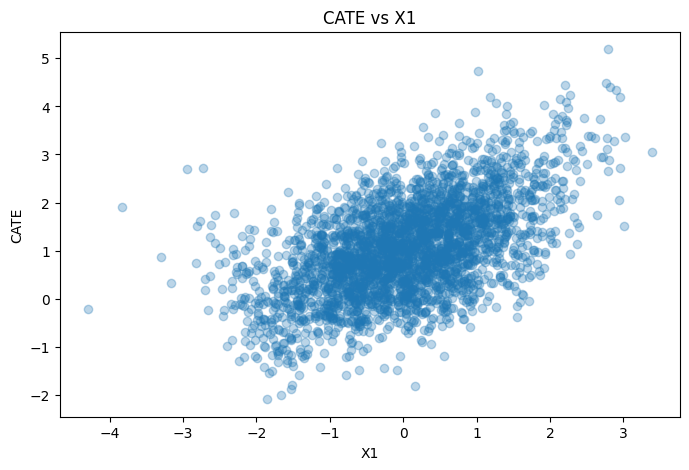

In [10]:
plt.figure(figsize=(8,5))
plt.scatter(data["X1"], data["CATE"], alpha=0.3)
plt.title("CATE vs X1")
plt.xlabel("X1")
plt.ylabel("CATE")
plt.show()


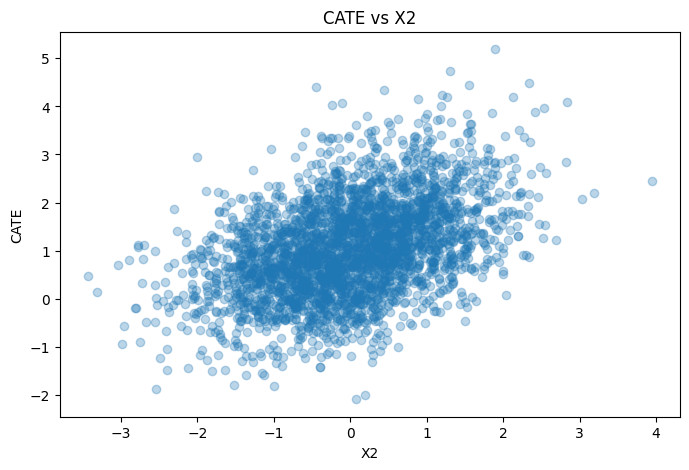

In [11]:
plt.figure(figsize=(8,5))
plt.scatter(data["X2"], data["CATE"], alpha=0.3)
plt.title("CATE vs X2")
plt.xlabel("X2")
plt.ylabel("CATE")
plt.show()


In [12]:
from sklearn.linear_model import LinearRegression

# Naive OLS: Y ~ T only (ignores confounding)
ols_model = LinearRegression()
ols_model.fit(data[["T"]], data["Y"])

ols_ate = ols_model.coef_[0]
ols_ate


np.float64(1.45592166538869)

In [13]:
print("Min propensity:", data["e_hat"].min())
print("Max propensity:", data["e_hat"].max())


Min propensity: 0.22
Max propensity: 0.775


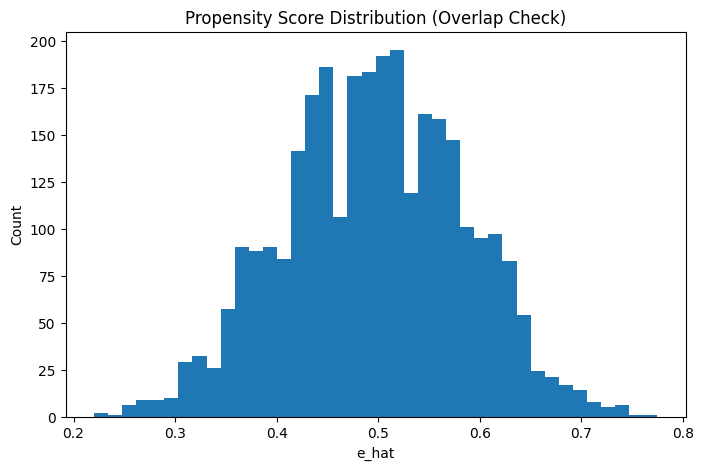

In [14]:
plt.figure(figsize=(8,5))
plt.hist(data["e_hat"], bins=40)
plt.title("Propensity Score Distribution (Overlap Check)")
plt.xlabel("e_hat")
plt.ylabel("Count")
plt.show()


In [15]:
import numpy as np

print("Mean of Y residuals:", np.mean(data["Y"] - data["m_hat"]))
print("Mean of T residuals:", np.mean(data["T"] - data["e_hat"]))


Mean of Y residuals: 0.001392481922690031
Mean of T residuals: 0.0004066666666666663
